In [159]:
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import acquire
from scipy import stats
import sklearn.preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

np.random.seed(123)

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date

In [160]:
# Pasting a code I found from itertools documentation.

def combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

In [161]:
zillow = acquire.get_zillow_data()

In [162]:
# Get a peek of the dataframe
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77574 entries, 0 to 77573
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77574 non-null  int64  
 1   parcelid                      77574 non-null  int64  
 2   airconditioningtypeid         25006 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77574 non-null  float64
 6   bedroomcnt                    77574 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49808 non-null  float64
 9   calculatedbathnbr             76959 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6035 non-null   float64
 12  calculatedfinishedsquarefeet  77374 non-null  float64
 13  f

In [163]:
# Create a function that will remove rows and columns that have missing values past a certain threshold.
def handle_missing_values(df, p_row = 0.84, p_col = 0.84):
    ''' function which takes in a dataframe, required notnull proportions of non-null rows and columns.
    drop the columns and rows columns based on theshold:'''
    
    #drop columns with nulls
    threshold = int(p_col * len(df.index)) # Require that many non-NA values.
    df.dropna(axis = 1, thresh = threshold, inplace = True)
    
    #drop rows with nulls
    threshold = int(p_row * len(df.columns)) # Require that many non-NA values.
    df.dropna(axis = 0, thresh = threshold, inplace = True)
    
    
    return df

In [164]:
b = handle_missing_values(zillow)

In [165]:
b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77474 entries, 0 to 77573
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77474 non-null  int64  
 1   parcelid                      77474 non-null  int64  
 2   bathroomcnt                   77474 non-null  float64
 3   bedroomcnt                    77474 non-null  float64
 4   calculatedbathnbr             76959 non-null  float64
 5   calculatedfinishedsquarefeet  77373 non-null  float64
 6   finishedsquarefeet12          73919 non-null  float64
 7   fips                          77474 non-null  float64
 8   fullbathcnt                   76959 non-null  float64
 9   latitude                      77474 non-null  float64
 10  longitude                     77474 non-null  float64
 11  lotsizesquarefeet             69300 non-null  float64
 12  propertycountylandusecode     77474 non-null  object 
 13  p

In [166]:
# Remove observations where bedroom and bathroom counts are zero.
b = b[b.bedroomcnt != 0]
b = b[b.bathroomcnt !=0]

In [167]:
b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76720 entries, 0 to 77573
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            76720 non-null  int64  
 1   parcelid                      76720 non-null  int64  
 2   bathroomcnt                   76720 non-null  float64
 3   bedroomcnt                    76720 non-null  float64
 4   calculatedbathnbr             76703 non-null  float64
 5   calculatedfinishedsquarefeet  76709 non-null  float64
 6   finishedsquarefeet12          73560 non-null  float64
 7   fips                          76720 non-null  float64
 8   fullbathcnt                   76703 non-null  float64
 9   latitude                      76720 non-null  float64
 10  longitude                     76720 non-null  float64
 11  lotsizesquarefeet             68569 non-null  float64
 12  propertycountylandusecode     76720 non-null  object 
 13  p

In [168]:
# Take a look at the amount of missing values.
b.isnull().sum()

id                                 0
parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
calculatedbathnbr                 17
calculatedfinishedsquarefeet      11
finishedsquarefeet12            3160
fips                               0
fullbathcnt                       17
latitude                           0
longitude                          0
lotsizesquarefeet               8151
propertycountylandusecode          0
propertylandusetypeid              0
rawcensustractandblock             0
regionidcity                    1447
regionidcounty                     0
regionidzip                       44
roomcnt                            0
yearbuilt                         65
structuretaxvaluedollarcnt        87
taxvaluedollarcnt                  1
assessmentyear                     0
landtaxvaluedollarcnt              1
taxamount                          5
censustractandblock              223
logerror                           0
t

In [169]:
# Create a list of columns to drop.
columns_to_drop = ['calculatedbathnbr','finishedsquarefeet12','id','transactiondate','parcelid','fullbathcnt','propertycountylandusecode','propertylandusetypeid','rawcensustractandblock','regionidcity','regionidcounty','regionidzip','censustractandblock','propertylandusedesc']

In [170]:
# Create a function that will drop unwanted columns.
def drop_columns(df, drop_col):
    df = df.drop(columns=drop_col)
    return df

In [171]:
b = drop_columns(b, columns_to_drop)

In [172]:
# use KNN imputer to fill missing values. 
from sklearn.impute import KNNImputer

# Quantitative columns used for imputation.
X_quant = b[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt','structuretaxvaluedollarcnt','taxvaluedollarcnt', 'landtaxvaluedollarcnt']]

# Define the imputer.
imputer = KNNImputer(n_neighbors=10)

# Fit the imputer on the train dataset. This method will transform it as well.
b_imputed = imputer.fit_transform(X_quant)

In [173]:
# Convert imputed array to a dataframe
b_imputed = pd.DataFrame(b_imputed, index = b.index)
#b_imputed.head()

# Assign imputed values to the original columns.
b[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 
       'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt']] = b_imputed



In [174]:
# Change yearbuilt to age

In [175]:
def yearbuilt_years(df):
    df.yearbuilt =  df.yearbuilt.astype(int)
    year = date.today().year
    df['age'] = year - df.yearbuilt
    # dropping the 'yearbuilt' column now that i have the age
    df = df.drop(columns=['yearbuilt'])
    return df

In [176]:
b = yearbuilt_years(b)

# New features created

In [178]:
# Create new features here
b['acres']= b.lotsizesquarefeet/43560


# ratio of bathrooms to bedrooms
b['bed_bath_ratio'] = b.bedroomcnt / b.bathroomcnt

# bin from brent
#b['age_bins'] = pd.cut(b.age, 10, labels=False)


# bin acres
b['acres_bin'] = pd.cut(b.acres, bins = [0, .10, .15, .25, .5, 1, 5, 10, 20, 50, 200], 
                    labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9])
    

b['land_dollar_per_sqft'] = b.landtaxvaluedollarcnt/b.lotsizesquarefeet

b['lot_dollar_sqft_bin'] = pd.cut(b.land_dollar_per_sqft, bins = [0, 1, 5, 20, 50, 100, 250, 500, 1000, 1500, 2000],
                                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                      )
b = b.astype({'acres_bin': float,  'lot_dollar_sqft_bin' : float})  #'age_bins': float,

In [179]:
b = b.dropna()

In [151]:
b.isna().sum()

bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
roomcnt                         0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
logerror                        0
age                             0
acres                           0
bed_bath_ratio                  0
age_bins                        0
acres_bin                       0
land_dollar_per_sqft            0
lot_dollar_sqft_bin             0
dtype: int64

### There are a few more columns with missing values that I will impute after I split.

In [180]:
# split test off, 20% of original df size. 
train_validate, test = train_test_split(b, test_size=.2, 
                                        random_state=42)

# split validate off, 30% of what remains (24% of original df size)
# thus train will be 56% of original df size. 
train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=42)

print("train observations: ", train.shape)
print("validate observations: ", validate.shape)
print("test observations: ", test.shape)

train observations:  (42959, 20)
validate observations:  (18412, 20)
test observations:  (15343, 20)


In [74]:
train.isnull().sum()

bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
roomcnt                         0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
logerror                        0
age                             0
acres                           0
bed_bath_ratio                  0
age_bins                        0
acres_bin                       0
land_dollar_per_sqft            0
lot_dollar_sqft_bin             0
dtype: int64

# Takeaway
* Initially I thought logerror would vary noticeably depending on the latitude and longitude. But, the logerror seems to be uniform all throughout the landscape.
* Maybe if I bin logerror I can get a better visualization.

In [31]:
# Create a bunch of bins for logerror to see if it will help with visualzing logerror when plotted on top of longitude vs latitude
train['logerror_bin'] = pd.cut(train.logerror, bins=np.arange(train.logerror.min(),train.logerror.max(),step=1.5))

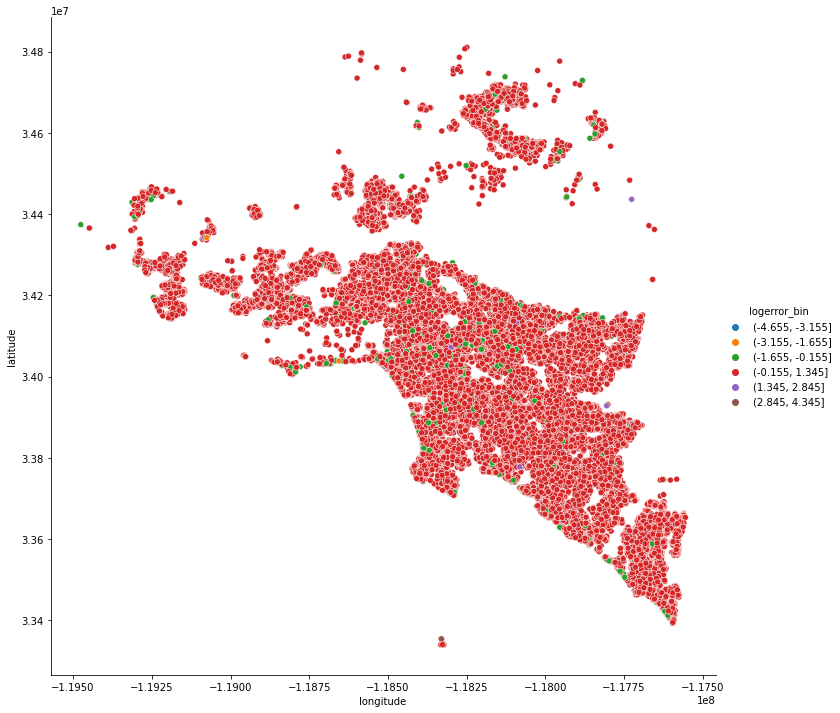

In [32]:
sns.relplot(train.longitude, train.latitude, hue=train.logerror_bin, height=10)

# Takeaways
* Binning the logerror made some of the observations stand out a little more, but I can't see any patterns as of now.
* Just call me Dora because I am about to...

### Explore!

### Target Variable: logerror
#### What will all our features look like plotted against the target (and everything else)?

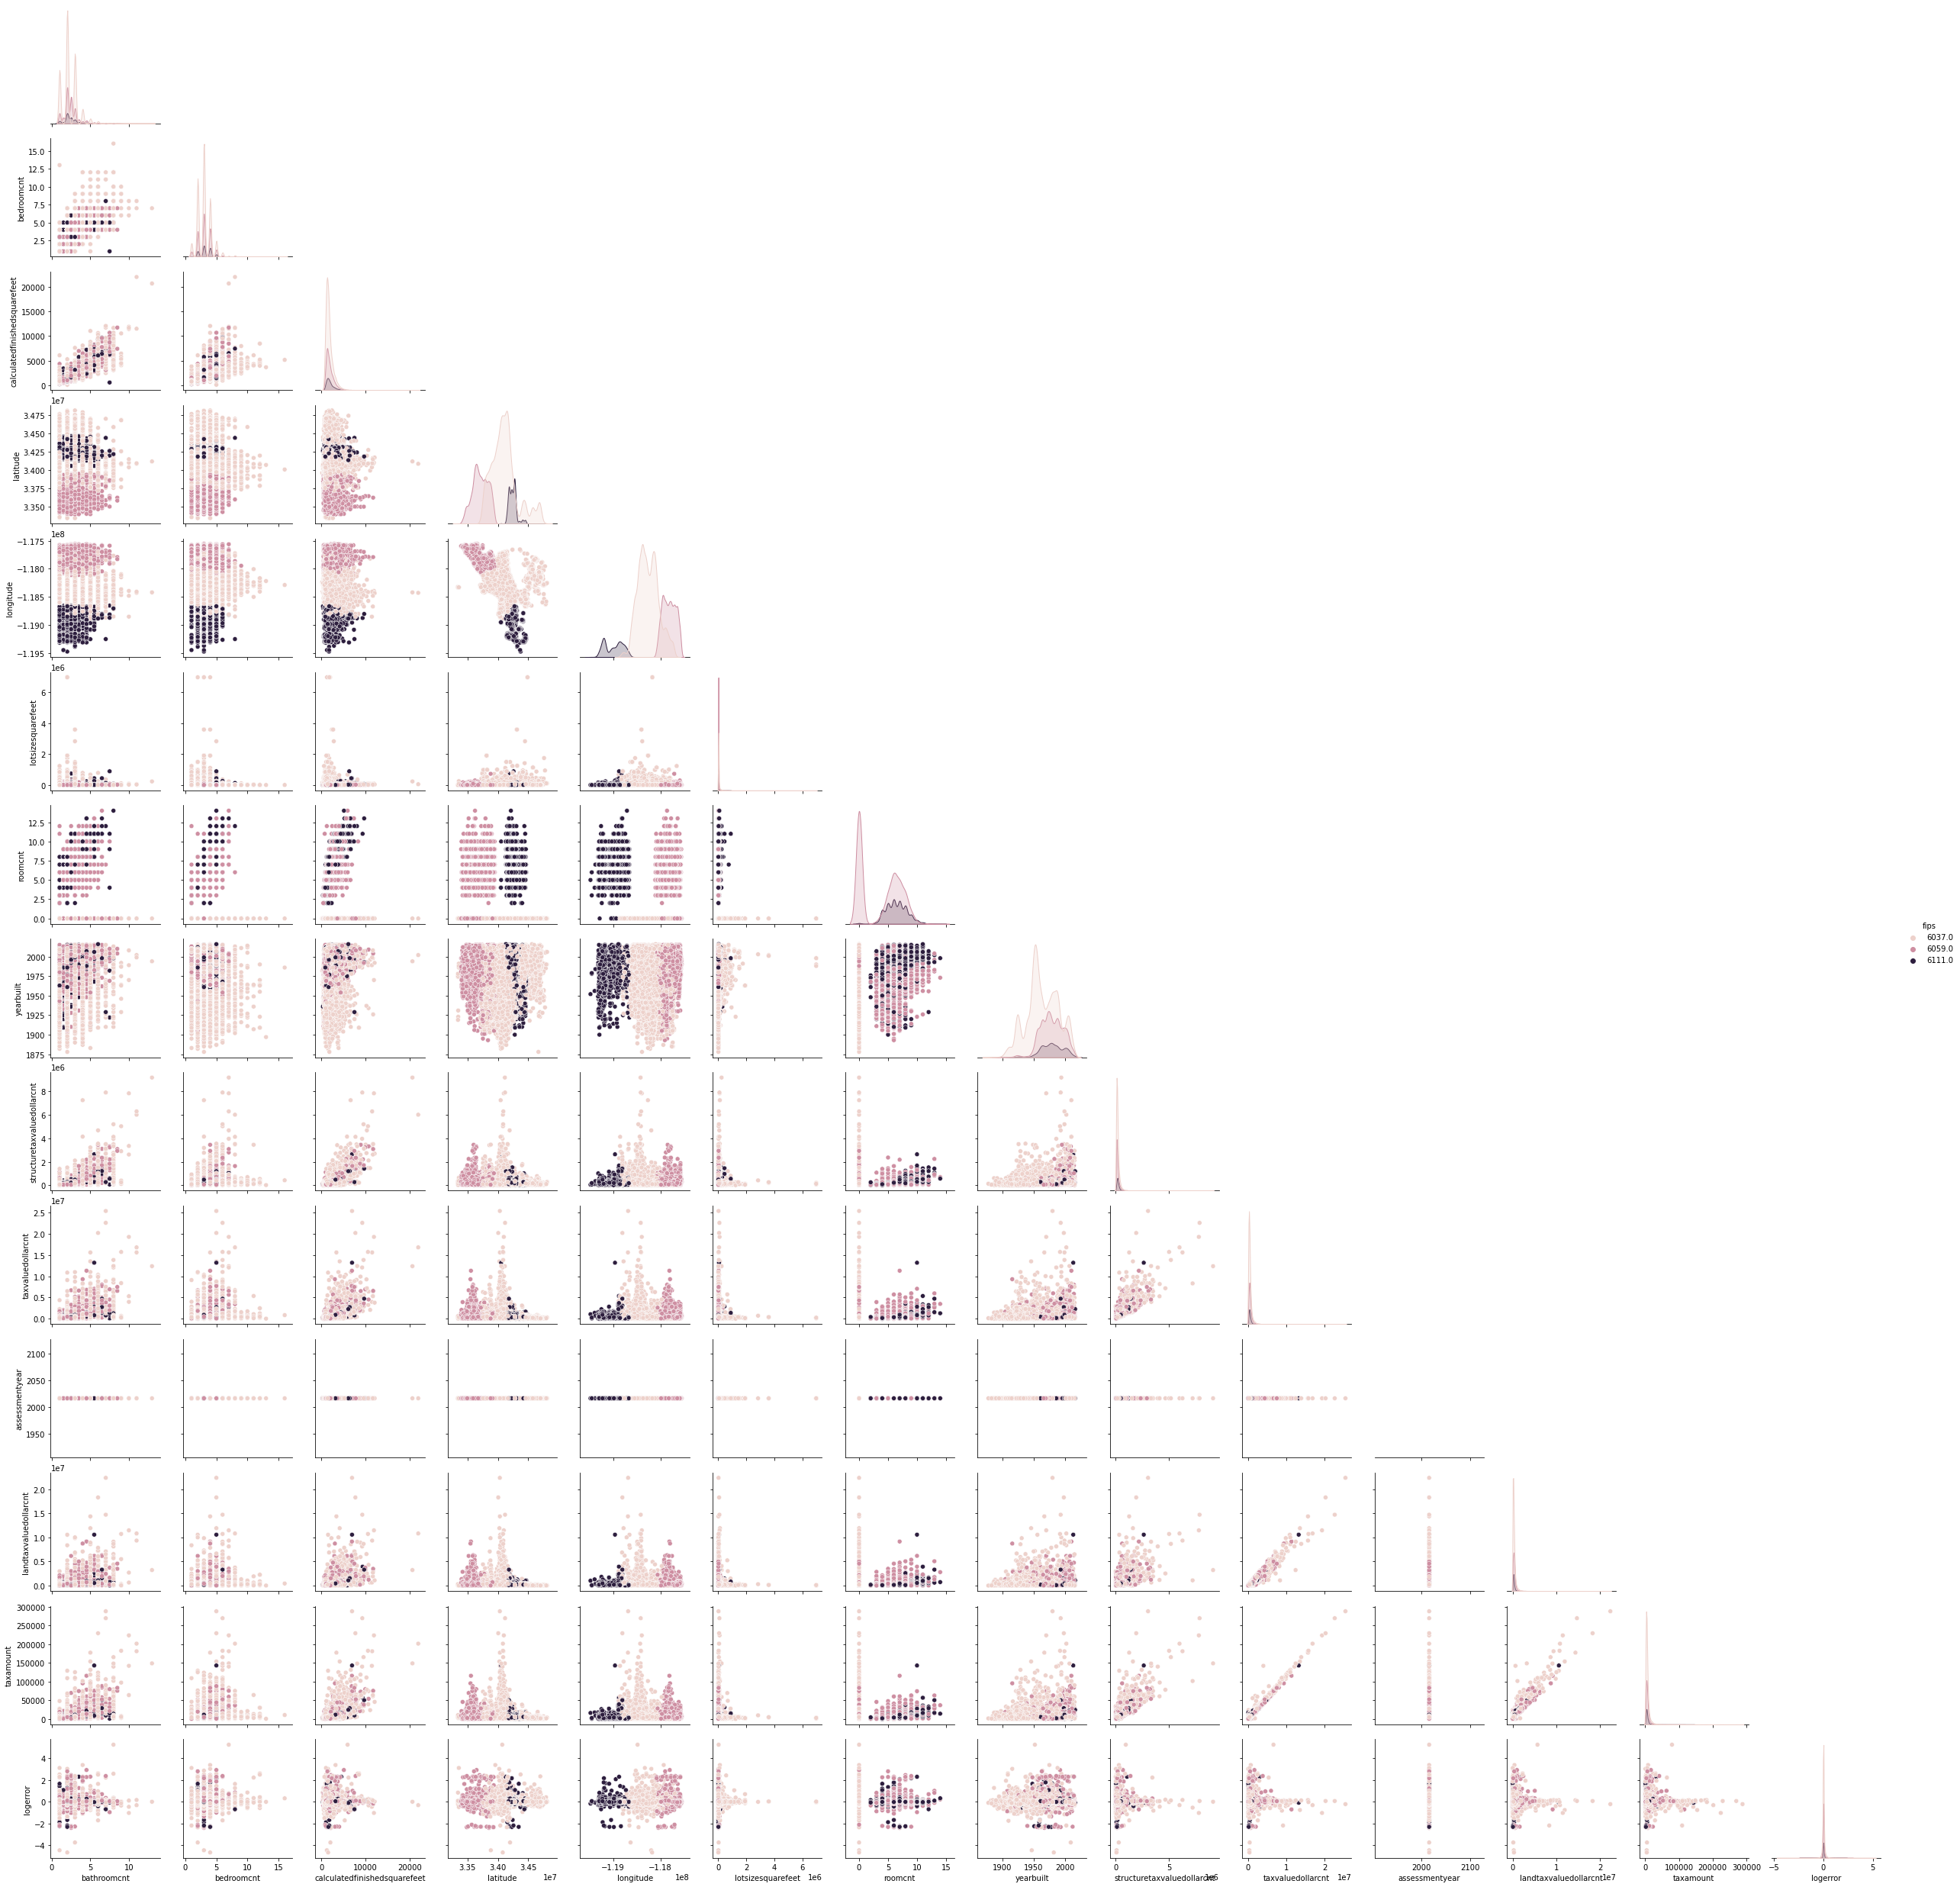

In [33]:
sns.pairplot(train, corner=True, hue='fips')

*** Create a function that will remove the target, iterate through a list of independent variables creating a list of the maximum combination of triplets.
-> Use the rfe_regressor to get the top 4 triplets that drives logerror

Text(0.5, 0, 'land_area')

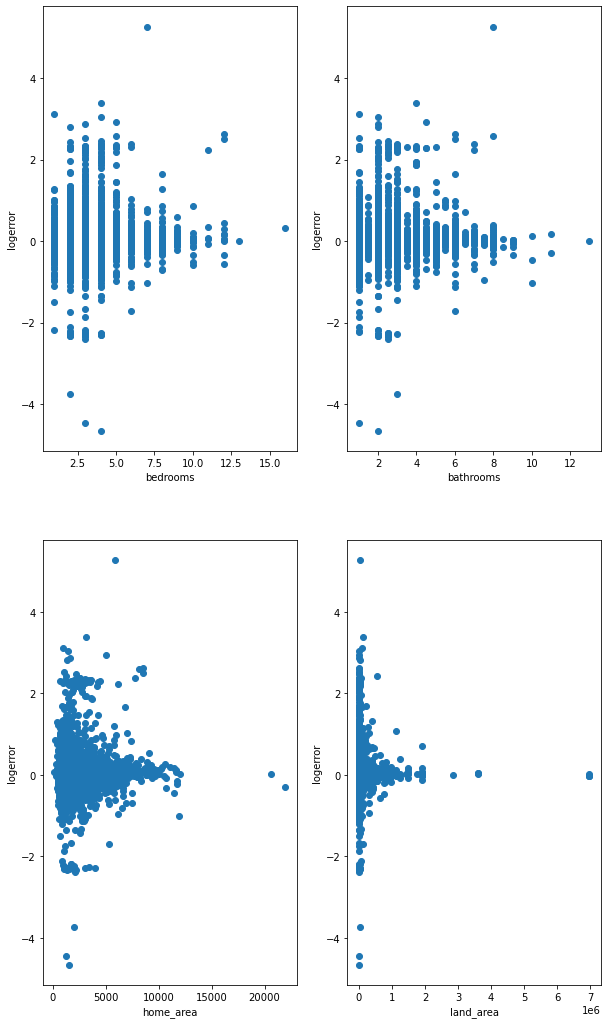

In [34]:
plt.figure(figsize=(10, 18))

plt.subplot(221)
plt.scatter(train.bedroomcnt, train.logerror)
plt.ylabel('logerror')
plt.xlabel('bedrooms')

plt.subplot(222)
plt.scatter(train.bathroomcnt, train.logerror)
plt.ylabel('logerror')
plt.xlabel('bathrooms')

plt.subplot(223)
plt.scatter(train.calculatedfinishedsquarefeet, train.logerror)
plt.ylabel('logerror')
plt.xlabel('home_area')

plt.subplot(224)
plt.scatter(train.lotsizesquarefeet, train.logerror)
plt.ylabel('logerror')
plt.xlabel('land_area')

In [103]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42959 entries, 41278 to 72921
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   42959 non-null  float64
 1   bedroomcnt                    42959 non-null  float64
 2   calculatedfinishedsquarefeet  42959 non-null  float64
 3   fips                          42959 non-null  float64
 4   latitude                      42959 non-null  float64
 5   longitude                     42959 non-null  float64
 6   lotsizesquarefeet             42959 non-null  float64
 7   roomcnt                       42959 non-null  float64
 8   structuretaxvaluedollarcnt    42959 non-null  float64
 9   taxvaluedollarcnt             42959 non-null  float64
 10  assessmentyear                42959 non-null  float64
 11  landtaxvaluedollarcnt         42959 non-null  float64
 12  taxamount                     42959 non-null  float64
 1

# Takeaways

* There doesn't seem to be any linear trend when plotting the independent variable against our target.
* There is a large variance in logerror among the lower end of the sepctrum across all variables.
* Small land area seems to have higher logerror.

## 1)Does age effect the logerror?

In [158]:
train.age_bins.value_counts()

2.0    11307
1.0    10700
3.0    10316
0.0     5996
4.0     3749
5.0      853
6.0       37
7.0        1
Name: age_bins, dtype: int64

In [200]:
train['age_bins'] = pd.cut(train.age, 10, labels=False)
validate['age_bins'] = pd.cut(validate.age, 10, labels=False)
test['age_bins'] = pd.cut(test.age, 10, labels=False)
#X_train['age_bins'] = pd.cut(train.yearbuilt, 10, labels=False)
#X_train_scaled['age_bins'] = pd.cut(train.yearbuilt, 10, labels=False)

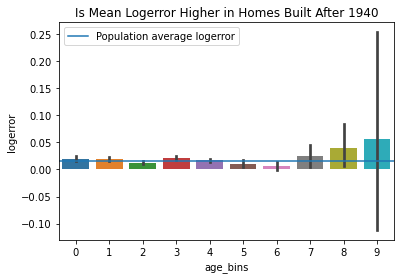

In [183]:
plt.title("Is Mean Logerror Higher in Homes Built After 1940")
sns.barplot(x="age_bins", y="logerror", data=train)
population_logerror_mean = train.logerror.mean()
plt.axhline(population_logerror_mean, label="Population average logerror")
plt.legend()
plt.show()

In [184]:
older_homes_logerror = train[train.age_bins <= 4].logerror
newer_homes_logerror = train[train.age_bins >= 5].logerror

### $H_0$: There is no difference in mean logerror between older homes and newer homes.
### $H_a$: There is a difference in mean logerror between older homes and newer homes.

In [185]:
# Check for equal variances.
# A stats Levene test - returns p value. small p-value means unequal variances.
t, p = stats.levene(older_homes_logerror, newer_homes_logerror)
# high p-value suggests that the populations have equal variances.

if p < alpha:
    print(f'p-value: {p}. There is unequal variance.')

p-value: 5.077633153002707e-88. There is unequal variance.


In [186]:
alpha = 0.05
# Run a Independent T-Test to test for a difference in mean logerror between newer homes and older homes.
t, p = stats.ttest_ind(older_homes_logerror, newer_homes_logerror, equal_var=False)
if p < alpha:
    print(f'p-value: {p}. We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

p-value: 0.04991037355968358. We reject the null hypothesis.


# Takeaway
* The mean logerror for newer homes seems to be greater than the mean logerror for older homes.

## 2) Does the mean logerror differ among the three counties?

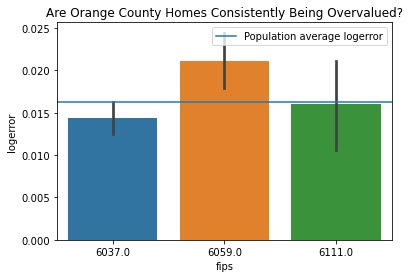

In [187]:
plt.title("Are Orange County Homes Consistently Being Overvalued?")
sns.barplot(x="fips", y="logerror", data=train)
population_logerror_mean = train.logerror.mean()
plt.axhline(population_logerror_mean, label="Population average logerror")
plt.legend()
plt.show()

# Takeaway
* The mean logerror of Orange County seems to be significantly higher than the population average.
* The mean logerror of Ventura County seems slightly higher than the population average.
* The mean logerror of LA County seems slightly lower than the population average.

In [188]:
# Create a dataframe for each county.
LA_county = train[train['fips']== 6037]
Ventura_county = train[train['fips']== 6111]
Orange_county = train[train['fips']== 6059]

# Create list of counties to make looping easier.
county_list = [LA_county, Ventura_county, Orange_county]

# Verify shape of new dataframes.
LA_county.shape, Ventura_county.shape, Orange_county.shape

# Create variables that hold the logerror values for each county.
LA_logerror = LA_county['logerror']
Ventura_logerror = Ventura_county['logerror']
Orange_logerror = Orange_county['logerror']

#### $H_0$: The mean logerror of Orange County is equal to the mean logerror of Ventura County.
#### $H_a$: The mean logerror of Orange County is greater than the mean logerror of Ventura County.

In [189]:
# A stats Levene test - returns p value. small p-value means unequal variances
print(stats.levene(LA_logerror, Ventura_logerror))
print(stats.levene(LA_logerror, Orange_logerror))
print(stats.levene(Ventura_logerror, Orange_logerror))
# high p-value suggests that the populations have equal variances

LeveneResult(statistic=16.608706183051446, pvalue=4.605171846058299e-05)
LeveneResult(statistic=38.81116906594106, pvalue=4.715476723939842e-10)
LeveneResult(statistic=0.0015335417366291626, pvalue=0.9687629854769042)


# Takeaway
* There are equal variances between LA County logerror and both Ventura County and Orange County logerror.
* There is an unqual variance between Ventura County logerror and Orange County logerror.
* I will set the equal_var argument to False for the Ventura_vs_Orange Independent T-Test.

In [190]:
alpha = 0.5
# Use a Kruskal-Wallis test to test for equality in mean logerror between the three counties.
t, p = stats.kruskal(LA_logerror, Ventura_logerror, Orange_logerror)
print(f'p-value: {p}')
if p < alpha:
    print("We reject the null hypothesis that the mean logerror of the three counties are equal.")
else:
    pinrt("We fail to reject the null hypothesis.")

p-value: 0.0003910922482866329
We reject the null hypothesis that the mean logerror of the three counties are equal.


# Takeaway
* There is a difference between the three counties in mean logerror. I will create dummy variables for the counties and use them as a features in my model. 

In [191]:
# Create dummy variables for the counties.
def get_counties(df):
    '''
    This function will create dummy variables out of the original fips column. 
    And return a dataframe with all of the original columns except regionidcounty.
    We will keep fips column for data validation after making changes. 
    New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
    The fips ids are renamed to be the name of the county each represents. 
    '''
    # create dummy vars of fips id
    county_df = pd.get_dummies(df.fips)
    # rename columns by actual county name
    county_df.columns = ['LA', 'Orange', 'Ventura']
    # concatenate the dataframe with the 3 county columns to the original dataframe
    df_dummies = pd.concat([df, county_df], axis = 1)
    # drop regionidcounty and fips columns
    return df_dummies

In [192]:
train = get_counties(train)
validate = get_counties(validate)
test = get_counties(test)

## 3)Does tax value effect the logerror?

<Figure size 1152x576 with 0 Axes>

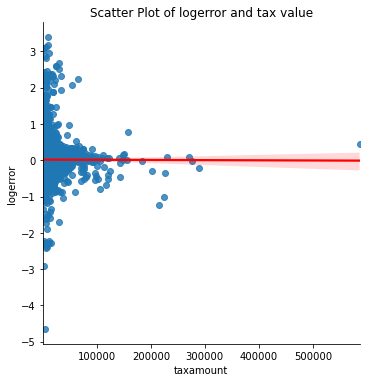

In [193]:
plt.figure(figsize=(16,8))
sns.lmplot(data = train, x = 'taxamount', y = 'logerror',line_kws={'color': 'red'})
plt.title("Scatter Plot of logerror and tax value")
plt.show()

### Takeaway
* We see no trend, so lets run a pearsons R test

#### H0: There is not linear correlation between the tax value and the logerror.

#### HA: There is linear correlation between the tax value and the logerror.

In [194]:
test_results = stats.pearsonr(train.logerror, train.taxamount)
r, p = test_results
print("r: ", r, "p: ", p)

r:  -0.002286349081902227 p:  0.6355939078938395


### Takeaway 
* There is not linear correlation with this low P-value!

## 4)Does area effect the logerror?

<Figure size 1152x576 with 0 Axes>

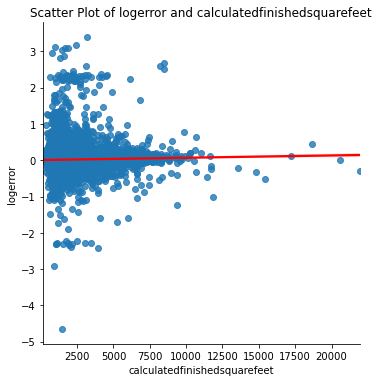

In [121]:
plt.figure(figsize=(16,8))
sns.lmplot(data = train, x = 'calculatedfinishedsquarefeet', y = 'logerror',line_kws={'color': 'red'})
plt.title("Scatter Plot of logerror and calculatedfinishedsquarefeet")
plt.show()

#### H0: There is not linear correlation between the area and the logerror.

#### HA: There is linear correlation between the area and the logerror.

In [122]:
test_results = stats.pearsonr(train.logerror, train.calculatedfinishedsquarefeet)
r, p = test_results
print("r: ", r, "p: ", p)

r:  0.036401193380460134 p:  4.4541871632099807e-14


### Takeaways
* There is a linear correlation between the area and logerror!

# Scaling the data

In [201]:
# Create a scaler object using the MinMaxScaler
scaler = sklearn.preprocessing.MinMaxScaler()

# Fit the scaler on the train dataset
# Use the select_dtypes to avoid an error when it tries to fit on the datetime datatype
scaler.fit(train.select_dtypes(include='number'))

# Use the scaler to transform the datasets
# Use the select_dtypes to avoid an error when it tries to transform on the datetime datatype
train_scaled = scaler.transform(train.select_dtypes(include='number'))
validate_scaled = scaler.transform(validate.select_dtypes(include='number'))
test_scaled = scaler.transform(test.select_dtypes(include='number'))

## Separate the target from the independent variables.

In [202]:
X_train = train.drop(columns='logerror')# , 'logerror_bin'
X_validate = validate.drop(columns='logerror')
X_test = test.drop(columns='logerror')

In [203]:
def Min_Max_Scaler(X_train, X_validate, X_test):
    """
    Takes in X_train, X_validate and X_test dfs with numeric values only
    Returns scaler, X_train_scaled, X_validate_scaled, X_test_scaled dfs 
    """
    scaler = sklearn.preprocessing.MinMaxScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), index = X_validate.index, columns = X_validate.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)
    
    return scaler, X_train_scaled, X_validate_scaled, X_test_scaled

In [204]:
scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Min_Max_Scaler(X_train, X_validate, X_test)

In [205]:
y_train = train[['logerror']]
y_validate = validate[['logerror']]
y_test = test[['logerror']]

### Checking for any other features through kbest and RFE top for top five

In [209]:
# Set the number of top features to present
k = 5

# Let's start with Select K Best
# Make the thing
kbest = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression, k=5)

# fit the thing
kbest.fit(X_train, y_train)

# use the thing, 
# get_support() produces an array of booleans, so we can filter out the column names that matter the most
kbest_features = X_train.columns[kbest.get_support()].tolist()

print("KBest's 5 best features are", kbest_features)

KBest's 5 best features are ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'roomcnt', 'Orange']


# Orange county and area area features here that we looked at!

In [207]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=5)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [208]:
rfe_feature

['calculatedfinishedsquarefeet',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount']

# Area, tax_value  are common values here too!

## For now we'll be using for our model, orange county dummy, area, age_bins, and tax_value for now!

### Set the baseline model

In [315]:
# 1. Predict logerror mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean
y_test['logerror_pred_mean'] = logerror_pred_mean

# 2. compute logerror_pred_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

# 3. RMSE of logerror_pred_mean
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean)**(1/2)
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 5))

# 4. RMSE of logerror_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 5))

RMSE using Mean
Train/In-Sample:  0.16586 
Validate/Out-of-Sample:  0.17528
RMSE using Median
Train/In-Sample:  0.16614 
Validate/Out-of-Sample:  0.17557


In [216]:
model1_train = X_train_scaled[['Orange', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'age_bins']]
model1_validate = X_validate_scaled[['Orange', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'age_bins']]
model1_test = X_test_scaled[['Orange', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'age_bins']]

### Try using a linear regression model (OLS)

In [229]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column since we added additional columns to y_train.
lm.fit(model1_train, y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(model1_train)

# evaluate: rmse
rmse_train_ols = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

# Now on validate
lm.fit(model1_validate, y_validate.logerror)
# predict validate
y_validate['logerror_pred_lm'] = lm.predict(model1_validate)

# evaluate: rmse
rmse_validate_ols = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.16614035434149663 
Validation/Out-of-Sample:  0.17556536413471427


### Try using a LassoLars model

In [230]:
# create the model object
lars = LassoLars(alpha=1.5)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(model1_train, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(model1_train)

# evaluate: rmse
rmse_train_laso = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)


lars.fit(model1_validate, y_validate.logerror)
# predict validate
y_validate['logerror_pred_lars'] = lars.predict(model1_validate)

# evaluate: rmse
rmse_validate_laso = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_laso, 
      "\nValidation/Out-of-Sample: ", rmse_validate_laso)

RMSE for Lasso + Lars
Training/In-Sample:  0.16586033349147408 
Validation/Out-of-Sample:  0.17528192047815916


## Try using polynomial

In [221]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

In [223]:
# fit and transform X_train_scaled
lars_train = pf.fit_transform(model1_train)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data.
# since we have converted it to a dataframe from a series! 
lm2.fit(lars_train, y_train.logerror)

# predict train
y_train['tax_pred_lm2'] = lm2.predict(lars_train)

# evaluate: rmse
rmse_train_poly = mean_squared_error(y_train.logerror, y_train.tax_pred_lm2)**(1/2)


# Now on validate
# fit and transform X_train_scaled
lars_validate = pf.fit_transform(model1_validate)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data.
# since we have converted it to a dataframe from a series! 
lm2.fit(lars_validate, y_validate.logerror)

# predict train
y_validate['tax_pred_lm2'] = lm2.predict(lars_validate)

# evaluate: rmse
rmse_validate_poly = mean_squared_error(y_validate.logerror, y_validate.tax_pred_lm2)**(1/2)


print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_poly, 
      "\nValidation/Out-of-Sample: ", rmse_validate_poly)

RMSE for Lasso + Lars
Training/In-Sample:  0.16553957044982567 
Validation/Out-of-Sample:  0.17465067871547066


In [234]:
# Takeaways
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 10), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 10))
print("------------------------------------------------")
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_ols, 
      "\nValidation/Out-of-Sample: ", rmse_validate_ols)
print("------------------------------------------------")
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_laso, 
      "\nValidation/Out-of-Sample: ", rmse_validate_laso)
print("------------------------------------------------")
print("RMSE for Poly w/o cluster\nTraining/In-Sample: ", rmse_train_poly, 
      "\nValidation/Out-of-Sample: ", rmse_validate_poly)

RMSE using Mean
Train/In-Sample:  0.1661403543 
Validate/Out-of-Sample:  0.1755653641
------------------------------------------------
RMSE for OLS using LinearRegression
Training/In-Sample:  0.16566451341350016 
Validation/Out-of-Sample:  0.17492944724600706
------------------------------------------------
RMSE for Lasso + Lars
Training/In-Sample:  0.16586033349147408 
Validation/Out-of-Sample:  0.17528192047815916
------------------------------------------------
RMSE for Lasso + Lars
Training/In-Sample:  0.16553957044982567 
Validation/Out-of-Sample:  0.17465067871547066


# Speaking of clusters...

### Lets cluster on our targets

In [289]:
# list of variables I will cluster on. 

cluster_vars = ['Orange', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'age_bins'] 
cluster_name = 'area_cluster'
k_range = range(2,20)

### Lets find our K value 

In [290]:
def find_k(x_train_scaled, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df

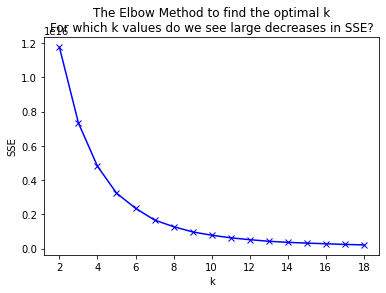

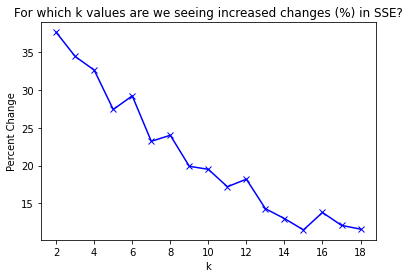

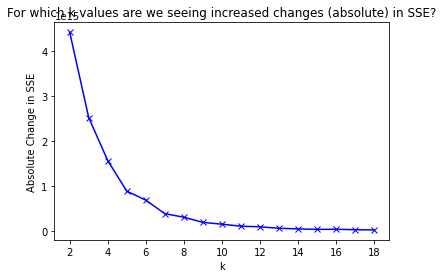

,k,sse,delta,pct_delta
0,2,1.175524e+16,4.424777e+15,37.6
1,3,7.330460e+15,2.524385e+15,34.4
2,4,4.806075e+15,1.566339e+15,32.6
3,5,3.239736e+15,8.875553e+14,27.4
4,6,2.352181e+15,6.870057e+14,29.2
5,7,1.665175e+15,3.862886e+14,23.2
6,8,1.278887e+15,3.069968e+14,24.0
7,9,9.718900e+14,1.930191e+14,19.9
8,10,7.788710e+14,1.518835e+14,19.5
9,11,6.269875e+14,1.076305e+14,17.2


In [291]:
find_k(X_train_scaled, cluster_vars, k_range)

### Lets select 5 clusters

In [292]:
#X = X_train_scaled[['latitude','longitude','yearbuilt']]
### Create Our Clusters
# Let's move forward with k=5
kmeans = KMeans(n_clusters = 6, random_state=420)
#kmeans.fit(x_train_scaled)
kmeans.fit(model1_train)

# And assign the cluster number to a column on the dataframe
model1_train["cluster"] = kmeans.predict(model1_train)
X_train_scaled["cluster"] = kmeans.predict(model1_train)
model1_train.head()

,Orange,calculatedfinishedsquarefeet,taxvaluedollarcnt,age_bins,cluster
41278,0.0,0.267025,0.009570,0.666667,0
73811,1.0,0.057630,0.009933,0.111111,1
31697,1.0,0.039262,0.005425,0.222222,1
72882,0.0,0.088763,0.005593,0.222222,2
33901,1.0,0.041190,0.003691,0.222222,1


In [293]:
kmeans.fit(model1_validate)

# And assign the cluster number to a column on the dataframe
model1_validate["cluster"] = kmeans.predict(model1_validate)
X_validate_scaled["cluster"] = kmeans.predict(model1_validate)
#model1_train.head()

kmeans.fit(model1_test)

# And assign the cluster number to a column on the dataframe
model1_test["cluster"] = kmeans.predict(model1_test)
X_test_scaled["cluster"] = kmeans.predict(model1_test)
#model1_train.head()

In [294]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=model1_train.columns)
centroids

,Orange,calculatedfinishedsquarefeet,taxvaluedollarcnt,age_bins,cluster
0,0.317261,0.072802,0.008418,3.000000e+00,5.000000e+00
1,0.047724,0.068770,0.009558,5.597916e+00,1.000000e+00
2,0.376234,0.086285,0.011745,1.000000e+00,2.000000e+00
3,0.353933,0.067052,0.008074,2.000000e+00,1.554312e-14
4,0.097360,0.061597,0.008291,4.000000e+00,3.000000e+00
5,0.312619,0.101644,0.015667,1.776357e-15,4.000000e+00


## Time to explore our clusters.

In [295]:
X_train_scaled.cluster.value_counts()

2    11147
3    10926
1     8118
4     6284
0     3589
5     2895
Name: cluster, dtype: int64

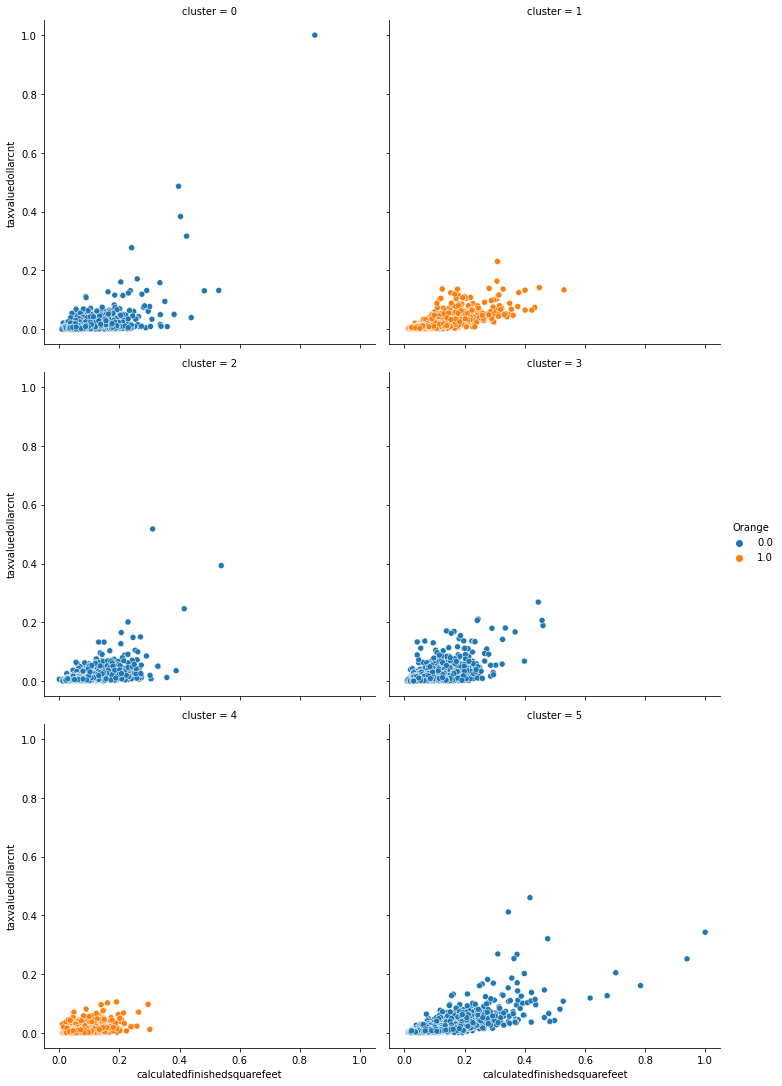

In [299]:
# plot out income vs. spending with regard to the cluster and age
sns.relplot(x=model1_train.calculatedfinishedsquarefeet, y=model1_train.taxvaluedollarcnt, 
            col=model1_train.cluster, hue=model1_train.Orange, col_wrap=2)



# Testing Cluster as a feature on models

In [300]:
model1_train.head()

,Orange,calculatedfinishedsquarefeet,taxvaluedollarcnt,age_bins,cluster
41278,0.0,0.267025,0.009570,0.666667,0
73811,1.0,0.057630,0.009933,0.111111,1
31697,1.0,0.039262,0.005425,0.222222,1
72882,0.0,0.088763,0.005593,0.222222,2
33901,1.0,0.041190,0.003691,0.222222,1


# OLS W/ Cluster

In [301]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column since we added additional columns to y_train.
lm.fit(model1_train, y_train.logerror)

# predict train
y_train['logerror_pred_lm_cluster'] = lm.predict(model1_train)

# evaluate: rmse
rmse_train_ols_cluster = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)

# Now on validate
lm.fit(model1_validate, y_validate.logerror)
# predict validate
y_validate['logerror_pred_lm_cluster'] = lm.predict(model1_validate)

# evaluate: rmse
rmse_validate_ols_cluster = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_ols_cluster, 
      "\nValidation/Out-of-Sample: ", rmse_validate_ols_cluster)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.16566451341350016 
Validation/Out-of-Sample:  0.17492944724600706


## Laso W/ Cluster

In [302]:
# create the model object
lars = LassoLars(alpha=1.5)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(model1_train, y_train.logerror)

# predict train
y_train['logerror_pred_lars_cluster'] = lars.predict(model1_train)

# evaluate: rmse
rmse_train_laso_cluster = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)


lars.fit(model1_validate, y_validate.logerror)
# predict validate
y_validate['logerror_pred_lars_cluster'] = lars.predict(model1_validate)

# evaluate: rmse
rmse_validate_laso_cluster = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_laso_cluster, 
      "\nValidation/Out-of-Sample: ", rmse_validate_laso_cluster)

RMSE for Lasso + Lars
Training/In-Sample:  0.16586033349147408 
Validation/Out-of-Sample:  0.17528192047815916


## Poly W/ Cluster

In [310]:
# fit and transform X_train_scaled
lars_train_cluster = pf.fit_transform(model1_train)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data.
# since we have converted it to a dataframe from a series! 
lm2.fit(lars_train_cluster, y_train.logerror)

# predict train
y_train['tax_pred_lm2_cluster'] = lm2.predict(lars_train_cluster)

# evaluate: rmse
rmse_train_poly_cluster = mean_squared_error(y_train.logerror, y_train.tax_pred_lm2_cluster)**(1/2)


# Now on validate
# fit and transform X_train_scaled
lars_validate_cluster = pf.fit_transform(model1_validate)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data.
# since we have converted it to a dataframe from a series! 
lm2.fit(lars_validate_cluster, y_validate.logerror)

# predict train
y_validate['tax_pred_lm2_cluster'] = lm2.predict(lars_validate_cluster)

# evaluate: rmse
rmse_validate_poly_cluster = mean_squared_error(y_validate.logerror, y_validate.tax_pred_lm2_cluster)**(1/2)


print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_poly_cluster, 
      "\nValidation/Out-of-Sample: ", rmse_validate_poly_cluster)

RMSE for Lasso + Lars
Training/In-Sample:  0.16553096280634622 
Validation/Out-of-Sample:  0.17441055854564758


In [311]:
# Takeaways

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 10), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 10))
print("------------------------------------------------")
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_ols_cluster, 
      "\nValidation/Out-of-Sample: ", rmse_validate_ols_cluster)
print("------------------------------------------------")
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_laso_cluster, 
      "\nValidation/Out-of-Sample: ", rmse_validate_laso_cluster)
print("------------------------------------------------")
print("RMSE for Poly\nTraining/In-Sample: ", rmse_train_poly_cluster, 
      "\nValidation/Out-of-Sample: ", rmse_validate_poly_cluster)

RMSE using Mean
Train/In-Sample:  0.1661403543 
Validate/Out-of-Sample:  0.1755653641
------------------------------------------------
RMSE for OLS using LinearRegression
Training/In-Sample:  0.16566451341350016 
Validation/Out-of-Sample:  0.17492944724600706
------------------------------------------------
RMSE for Lasso + Lars
Training/In-Sample:  0.16586033349147408 
Validation/Out-of-Sample:  0.17528192047815916
------------------------------------------------
RMSE for Poly
Training/In-Sample:  0.16553096280634622 
Validation/Out-of-Sample:  0.17441055854564758


# Poly won lets see how did compared without our cluster

In [312]:
print("------------------------------------------------")
print("RMSE for Poly\nTraining/In-Sample: ", rmse_train_poly_cluster, 
      "\nValidation/Out-of-Sample: ", rmse_validate_poly_cluster)
print("------------------------------------------------")
print("RMSE for Poly w/o cluster\nTraining/In-Sample: ", rmse_train_poly, 
      "\nValidation/Out-of-Sample: ", rmse_validate_poly)

------------------------------------------------
RMSE for Poly
Training/In-Sample:  0.16553096280634622 
Validation/Out-of-Sample:  0.17441055854564758
------------------------------------------------
RMSE for Poly w/o cluster
Training/In-Sample:  0.16553957044982567 
Validation/Out-of-Sample:  0.17465067871547066


## Our model w/ cluster beat the previous one without our cluster feature!

# Lets put it on test now!

In [314]:
# Now on validate
# fit and transform X_train_scaled
lars_test_cluster = pf.fit_transform(model1_test)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data.
# since we have converted it to a dataframe from a series! 
lm2.fit(lars_test_cluster, y_test.logerror)

# predict train
y_test['tax_pred_lm2_cluster'] = lm2.predict(lars_test_cluster)

# evaluate: rmse
rmse_test_poly_cluster = mean_squared_error(y_test.logerror, y_test.tax_pred_lm2_cluster)**(1/2)


print("RMSE for Poly W/ Cluster\nTest/In-Sample: ", rmse_test_poly_cluster)

RMSE for Poly W/ Cluster
Test/In-Sample:  0.16794718370480538


In [317]:
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_test, 5),
      "\nRMSE using poly w/ cluster: ", rmse_test_poly_cluster)

RMSE using Median
Train/In-Sample:  0.1687 
RMSE using poly w/ cluster:  0.16794718370480538


In [318]:
rmse_test_poly_cluster/rmse_test

0.9955437068012456

#### 1% Difference w/ our model compared to baseline

## Looking at our clusters

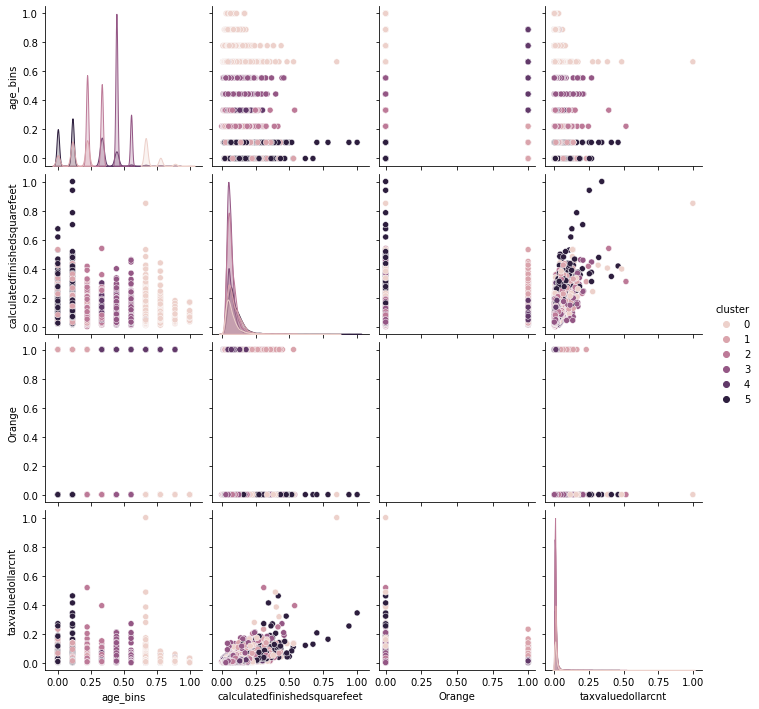

In [321]:
plt_df = model1_train[['age_bins', 'calculatedfinishedsquarefeet', 
                    'Orange', 'taxvaluedollarcnt', 'cluster']]

sns.pairplot(data=plt_df, hue='cluster')

# Takeaways

Looking at our questions: 
- counties (orange county)
- looking at how age affects logerror
- area and logerror
- if tax value affects logerror

Looking at my questions I found taht they all held a significance for assessing the tax value of a home! When creating our model, I found that the polynomial with 2 degrees was best suited for the job beating the baseline by 13% and will perform better with future unseen data!

# Recommendations

I recommend that you use my model for most of the future data if using the same criteria, seen in my report the model will start under predicting higher value homes so this may become a issue other wise!

# Next time

With more time I would like to create different models for each individual county/ bathroom count/ bedroom counts/ pools/ garages / garage sqft / roomcnt /
etc. Though my model beat baseline I believe there is a larger room for improvement!

Also for further research targets more features using RFE and taking a closer looking at the features EX: area, La County, and roomcnt and maybe inlcuding more columns to see what else it'll indicating having a strong relationship towards tax value!